In [2]:
import PIL.Image as Image
import numpy as np
import pycocotools.mask as rletools
import glob
import os
import cv2
from concurrent.futures import ProcessPoolExecutor


class SegmentedObject:
  def __init__(self, mask, class_id, track_id):
    self.mask = mask
    self.class_id = class_id
    self.track_id = track_id

  

def load_sequences(path, seqmap):
  objects_per_frame_per_sequence = {}
  for seq in seqmap:
    print("Loading sequence", seq)
    seq_path_folder = os.path.join(path, seq)
    seq_path_txt = os.path.join(path, seq + ".txt")
    if os.path.isdir(seq_path_folder):
      print("here")
      objects_per_frame_per_sequence[seq] = load_images_for_folder(seq_path_folder)
    elif os.path.exists(seq_path_txt):
      print("ho")
      objects_per_frame_per_sequence[seq] = load_txt(seq_path_txt)
    else:
      assert False, "Can't find data in directory " + path

  return objects_per_frame_per_sequence


def load_txt(path):
  objects_per_frame = {}
  track_ids_per_frame = {}  # To check that no frame contains two objects with same id
  combined_mask_per_frame = {}  # To check that no frame contains overlapping masks
  with open(path, "r") as f:
    for line in f:
      line = line.strip()
      fields = line.split(" ")

      frame = int(fields[0])
      if frame not in objects_per_frame:
        objects_per_frame[frame] = []
      if frame not in track_ids_per_frame:
        track_ids_per_frame[frame] = set()
      if int(fields[1]) in track_ids_per_frame[frame]:
        assert False, "Multiple objects with track id " + fields[1] + " in frame " + fields[0]
      else:
        track_ids_per_frame[frame].add(int(fields[1]))

      class_id = int(fields[2])
      if not(class_id == 1 or class_id == 2 or class_id == 10):
        assert False, "Unknown object class " + fields[2]

      mask = {'size': [int(fields[3]), int(fields[4])], 'counts': fields[5].encode(encoding='UTF-8')}
      if frame not in combined_mask_per_frame:
        combined_mask_per_frame[frame] = mask
      elif rletools.area(rletools.merge([combined_mask_per_frame[frame], mask], intersect=True)) > 0.0:
        assert False, "Objects with overlapping masks in frame " + fields[0]
      else:
        combined_mask_per_frame[frame] = rletools.merge([combined_mask_per_frame[frame], mask], intersect=False)
      objects_per_frame[frame].append(SegmentedObject(
        mask,
        class_id,
        int(fields[1])
      ))

  return objects_per_frame


def load_images_for_folder(path):
  files = sorted(glob.glob(os.path.join(path, "*.png")))

  objects_per_frame = {}
  for file in files:
    print(file)
    objects = load_image(file)
    frame = filename_to_frame_nr(os.path.basename(file))
    objects_per_frame[frame] = objects

  return objects_per_frame


def filename_to_frame_nr(filename):
  assert len(filename) == 10, "Expect filenames to have format 000000.png, 000001.png, ..."
  return int(filename.split('.')[0])


def load_image(filename, id_divisor=1000):
  img = np.array(cv2.imread(filename))
  obj_ids = np.unique(img)

  objects = []
  mask = np.zeros(img.shape, dtype=np.uint8, order="F")  # Fortran order needed for pycocos RLE tools
  for idx, obj_id in enumerate(obj_ids):
    if obj_id == 0:  # background
      continue
    mask.fill(0)
    pixels_of_elem = np.where(img == obj_id)
    mask[pixels_of_elem] = 1
    objects.append(SegmentedObject(
      rletools.encode(mask),
      obj_id // id_divisor,
      obj_id
    ))

  return objects


def load_seqmap(seqmap_filename):
  print("Loading seqmap...")
  seqmap = []
  max_frames = {}
  with open(seqmap_filename, "r") as fh:
    for i, l in enumerate(fh):
      fields = l.split(" ")
      seq = "%04d" % int(fields[0])
      seqmap.append(seq)
      max_frames[seq] = int(fields[3])
  return seqmap, max_frames


def write_sequences(gt, output_folder):
  os.makedirs(output_folder, exist_ok=True)
  for seq, seq_frames in gt.items():
    write_sequence(seq_frames, os.path.join(output_folder, seq + ".txt"))
  return


def write_sequence(frames, path):
  with open(path, "w") as f:
    for t, objects in frames.items():
      for obj in objects:
        print(t, obj.track_id, obj.class_id, obj.mask["size"][0], obj.mask["size"][1],
              obj.mask["counts"].decode(encoding='UTF-8'), file=f)

In [3]:
import torch
from torch.utils.data.dataset import Dataset
import os
from pycocotools import mask as mask_utils
import numpy as np
import glob
import cv2

CLASS_MAPPING = {
    1: 3,  # car → COCO car
    2: 1,  # pedestrian → COCO person
}

CLASS_MAPPING = {
    1: 3,  # car → COCO car
    2: 1,  # pedestrian → COCO person
}

class KittyDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.load_data("/home/msiau/workspace/jventosa/PostTFG/Master/C5_Team3/Week1/src/utils/train.seqmap")

    def load_data(self, seqmap):

        image_data = []
        label_data = []
        seqmaps, _ = load_seqmap(seqmap)

        for seq in seqmaps:
            seq_path_txt = os.path.join(self.root_dir, "instances_txt", seq + ".txt")
            seq_path_folder = os.path.join(self.root_dir, "training", "image_02", seq)

            text = load_txt(seq_path_txt)
            images = sorted(glob.glob(os.path.join(seq_path_folder, "*.png")))

            for image_path in images:
                frame = filename_to_frame_nr(os.path.basename(image_path))

                if frame not in text:
                    continue

                # ---- IMAGE ----
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = torch.as_tensor(img, dtype=torch.float32)
                img = img.permute(2, 0, 1)  # HWC → CHW
                img /= 255.0

                boxes = []
                labels = []

                for obj in text[frame]:
                    bbox = mask_utils.toBbox(obj.mask)  # [x,y,w,h]

                    x, y, w, h = bbox
                    if obj.class_id not in CLASS_MAPPING:
                        continue

                    boxes.append([x, y, x + w, y + h])  # convert to xyxy
                    
                    labels.append(CLASS_MAPPING[obj.class_id])
                if len(boxes) == 0:
                    continue
                boxes = torch.as_tensor(boxes, dtype=torch.float32)
                labels = torch.as_tensor(labels, dtype=torch.int64)

                target = {
                    "boxes": boxes,
                    "labels": labels,
                }

                image_data.append(img)
                label_data.append(target)

        self.images = image_data
        self.labels = label_data

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

dataset = KittyDataset("/home/msiau/workspace/jventosa/PostTFG/Master/C5_Team3/Week1/datasets/KITTI-MOTS")


Loading seqmap...


In [20]:
dataset = KittyDataset("/home/msiau/data/tmp/jventosa/KITTI-MOTS",[1,2,3])

In [30]:
print(len(dataset))

4520


In [ ]:
dataset[1]

(array([[[255, 255, 173],
         [255, 255, 173],
         [255, 255, 177],
         ...,
         [255, 255, 254],
         [255, 255, 252],
         [255, 255, 243]],
 
        [[255, 255, 173],
         [255, 255, 173],
         [255, 255, 175],
         ...,
         [250, 255, 255],
         [242, 255, 249],
         [238, 236, 234]],
 
        [[255, 255, 184],
         [255, 255, 184],
         [255, 255, 180],
         ...,
         [222, 247, 209],
         [216, 199, 178],
         [210, 132, 136]],
 
        ...,
 
        [[176, 185, 218],
         [182, 199, 227],
         [185, 211, 215],
         ...,
         [ 22,  18,  14],
         [ 22,  18,  13],
         [ 22,  18,  13]],
 
        [[178, 184, 234],
         [176, 199, 234],
         [175, 202, 211],
         ...,
         [ 20,  16,  14],
         [ 20,  17,  14],
         [ 21,  17,  13]],
 
        [[178, 177, 177],
         [175, 177, 171],
         [175, 173, 178],
         ...,
         [ 21,  15,  13],
  

In [27]:
def collate_fn(batch):
    return tuple(zip(*batch))




loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

TypeError: Invalid shape (3, 375, 1242) for image data

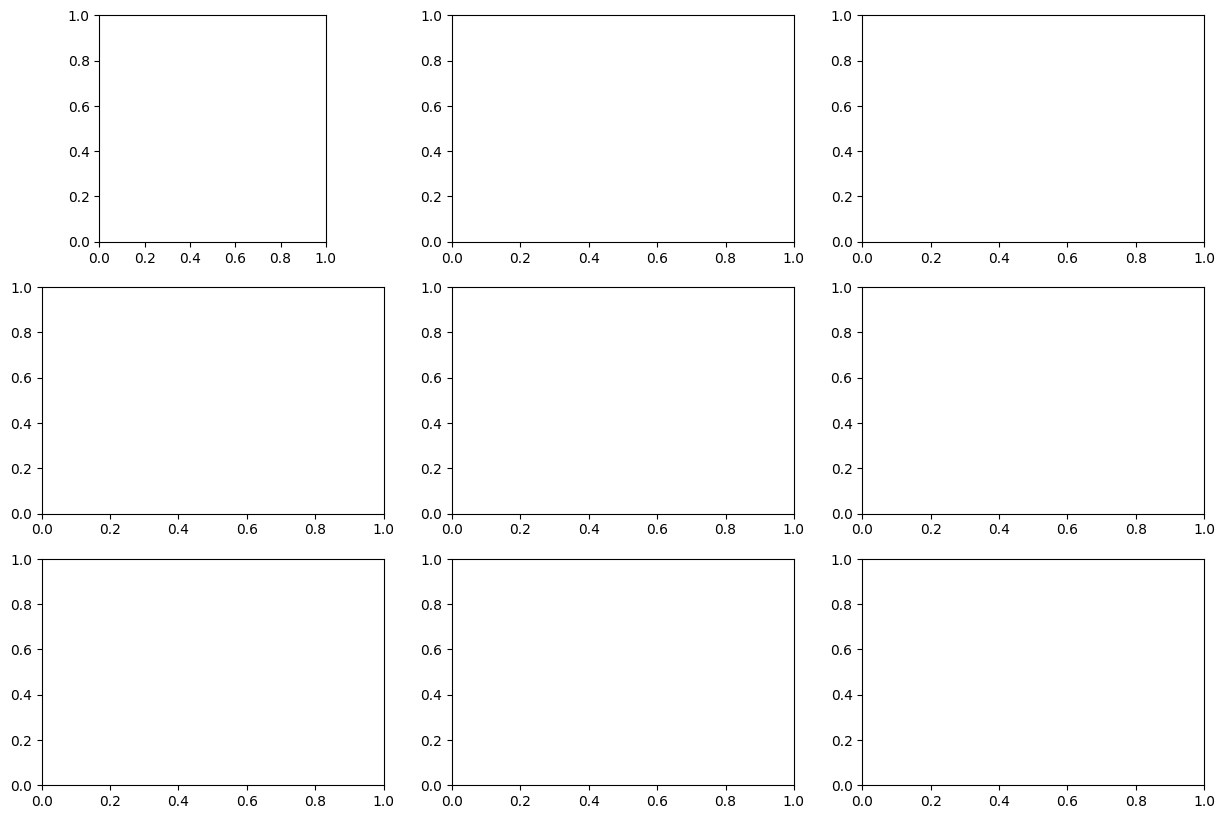

In [ ]:

import numpy as np
from PIL import Image, ImageDraw
import torchvision
from matplotlib import pyplot as plt

from torchvision.utils import draw_bounding_boxes

def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample[0] # This is a Tensor (C, H, W)
    annotations = sample[1]
    
    # Convert to PIL to use ImageDraw
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    draw = ImageDraw.Draw(pil_img)
    
    for i in range(len(annotations["boxes"])):
        box = annotations["boxes"][i].numpy()
        x1, y1, x2, y2 = tuple(box)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=3)
        draw.text((x1, y1), "yes", fill="green")

    # Convert back to Tensor so the rest of your code works
    return pil_img

import matplotlib.pyplot as plt

def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_cols = 3
    num_rows = int(np.ceil(len(indices) / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        image = draw_image_from_idx(dataset, idx)

        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

plot_images(dataset, range(9))